In [ ]:
from nnModel import getModel
model = getModel("gz_dev.model")

In [ ]:
import re
import shutil
import os
import time
from os.path import isfile, join
from subprocess import Popen

from nnTrainingSession import NNTrainingSession
from nnTrainingFile import createTrainingFiles

currentDir = '.'
gameSourceDir = "D:/GalconZero/Games/"
gameArchiveDirPrefix = "D:/GalconZero/OldGames/Iter"
modelArchiveDir = "D:/GalconZero/OldModels"

NUM_FILES_PER_ITERATION = 100

botProcess = None

session = NNTrainingSession(model)

def restartBots():
    botBasePath = r"C:\Users\Evan Sparano\Documents\GitHub\galcon-alphazero\gbots"
    botProcess = Popen(botBasePath + "\launch8Bots.bat", cwd=botBasePath)

def killBots():
    # TODO: this only kills one bot process? not all of them?
    if botProcess != None:
        os.kill(botProcess.pid, signal.SIGTERM)
    
def archiveGames(iterationNum):
    archiveDir = gameArchiveDirPrefix + str(iterationNum)
    os.makedirs(archiveDir)

    files = os.listdir(gameSourceDir)
    for f in files:
        if 'npz' in f:
            shutil.move(gameSourceDir+f, archiveDir)
        else:
            os.remove(gameSourceDir+f)

def getCurrentIteration():
    onlyFiles = [f for f in os.listdir(modelArchiveDir) if isfile(join(modelArchiveDir, f)) and 'iter' in f]
    return max([ int(re.findall(r'\d+', filename)[0]) for filename in onlyFiles], default=-1) + 1

def trainModel():
    session.doTrain(num_loops=1, numGamesPerLoop=-1, numEpochs=2)
    print("trained the model!")

def nextIteration():
    # TODO: this isn't actually killing the bots, so the bots keep generating unused games while model is training
#     killBots()
    
    prevIterNum = getCurrentIteration()
    model.save(modelArchiveDir + '/gz_dev.iter{0}.model'.format(prevIterNum))
    
    trainModel()
    model.save("gz_dev.model")
    
    archiveGames(prevIterNum)
    
    restartBots()
    
def startTrainingLoop(maxIterations=3):
    restartBots()
    
    while getCurrentIteration() < maxIterations:
        time.sleep(1)
        createTrainingFiles()
        files = os.listdir(gameSourceDir)
        # multiply by two because of pickle and npz files
        if len(files) >= NUM_FILES_PER_ITERATION * 2:
            nextIteration()
            
    killBots()
    

In [ ]:
startTrainingLoop(10000)

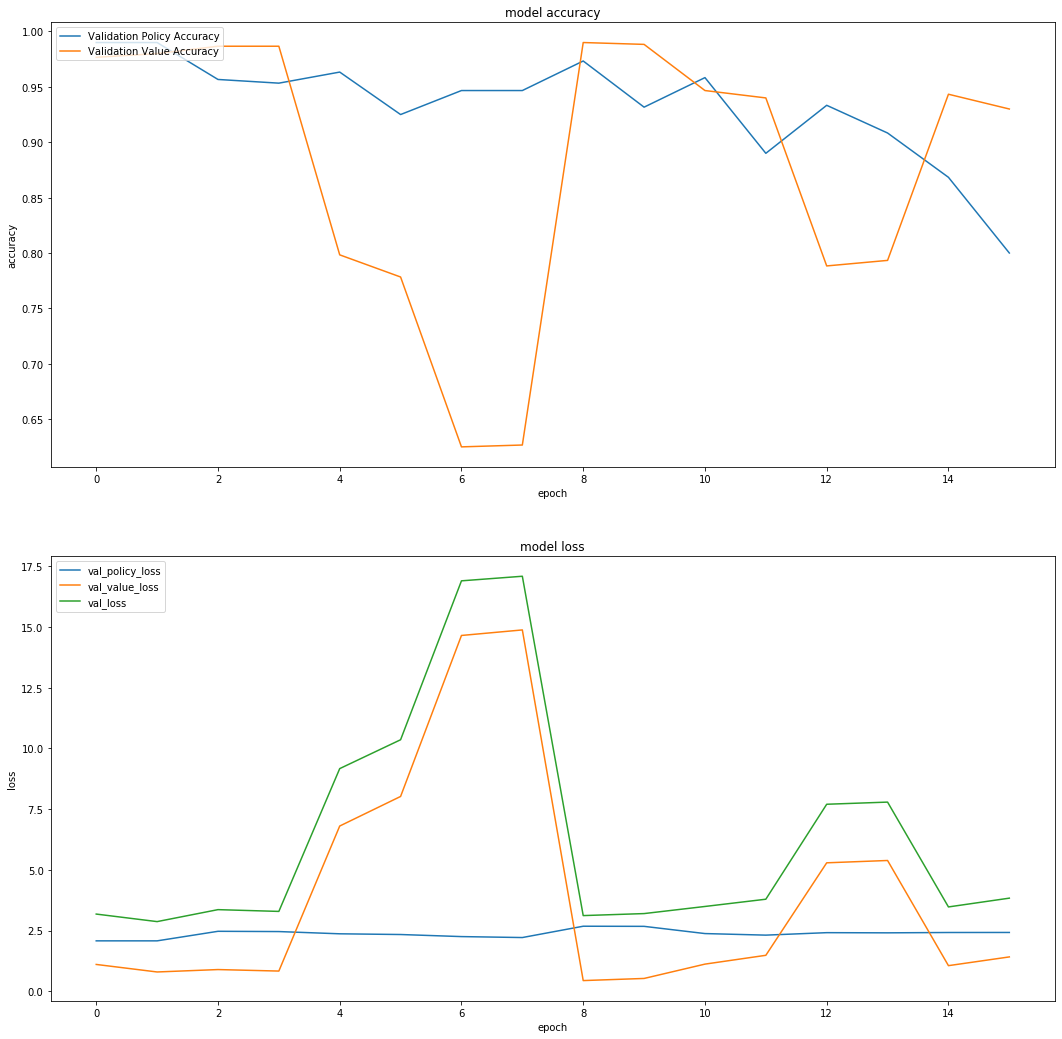

In [4]:
from nnTrainingGraph import plotNNTrainingSession

plotNNTrainingSession(session)